# Dynamic Control Systems

**WARNING:** Some cells in this notebook are not meant to be run sequentially!

In [54]:
import sys
sys.path.append('..')

In [55]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [56]:
from ctrl.algo import Proportional, PID, VelocityController, OpenLoop

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [57]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
controller = Controller(HOST, PORT)

## Dynamic Response of the DC motor

So far we have been ignoring the fact that the DC motor *takes some time* to accelerate and reach a certain velocity. A linear model of the form:

$$
    \text{velocity} = G \, \text{control}
$$

can not capture **dynamic effects** of the DC motor. A measure of the **speed** of a system is the **time-constant**, $\tau$. The time-constant is the time that the output of system, starting from zero, takes to reach $63\%$ of its final constant value. In practice it is easier to measure the **rise-time**, $t_r$, which is the time it takes the output to go from $10\%$ to $90\%$ of its final constant value. The time-constant and the rise-time are related by $t_r = 2.2 \tau$

**TASKS:**
1. Run the following code to study the dynamic response of the DC motor
2. Import the data and plot time *vs* velocity and time *vs* control
3. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the final velocity
4. Zoom in the first second and calculate the time the response reaches $10\%$ and the $90\%$ of its final value and subtract to estimate the rise-time
5. Calculate the time-constant

**QUESTIONS:**
1. Can you think of other phenomena that have a similar dynamic characteristic?
2. What about different time-constants?
3. Name a dynamic phenomenon that has a smaller time- constant
4. Name a dynamic phenomenon that has a much larger time-constant

In [58]:
controller.set_controller1(OpenLoop())
controller.reset_logger()
controller.set_encoder1(0)
with controller:
    controller.set_reference1(80)
    time.sleep(3)
log = controller.get_log()

In [59]:
# SOLUTIONS 1,2,3,4

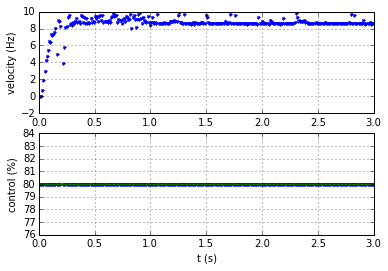

In [60]:
# SOLUTION 1
t = log[:,0]
position = log[:,1]
reference = log[:,2]
control = log[:,3]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

plt.subplot(2,1,1)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, control, '.', t, reference, '-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

In [61]:
# SOLUTION 2
ind, = np.where(t > 1)
vmean = np.mean(velocity[ind[0]:])
vstd = np.std(velocity[ind[0]:])
print('mean = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,vstd))

mean = 8.752, standard deviation = 0.261


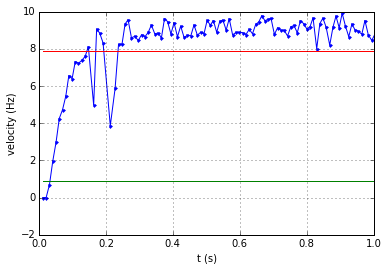

In [62]:
# SOLUTION 3
plt.plot(t, velocity, '.-', 
         np.array([t[0],t[-1]]), np.array(2*[0.1*vmean]), '-',
         np.array([t[0],t[-1]]), np.array(2*[0.9*vmean]), '-')
plt.xlim(0,1)
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

In [63]:
# SOLUTION 4
tr = t[np.where(velocity >= 0.9*vmean)][1] - t[np.where(velocity >= 0.1*vmean)][0] 
tau = tr / 2.2
print('tr = {:5.3f}, tau = {:5.3f}'.format(tr, tau))

tr = 0.131, tau = 0.060


## Closed-loop Dynamic Response

The time-constant of a controlled system is affected by feedback in much the same way that the gain is. Indeed, one can show that in the case of the velocity proportional feedback:

$$
\begin{aligned}
    \frac{\tau_{cl}}{\tau_{ol}} &= S, & S &= \frac{1}{1 + K G}
\end{aligned}
$$

The quantity $S$ is known as **sensitivity**.

**TASKS:**
1. Run the following code to implement a proportional velocity controller
2. Import the data and plot time *vs* velocity and time *vs* control
3. Proceed as above to calcualte the closed-loop time-constant
4. Calculate the ratio between the open-loop time-constant and the closed-loop time-constant
5. Repeat the above steps with a proportional gain `Kp` equal to 2 then 4

**QUESTIONS:**
1. What is the effect of the control gain on the time-response?
2. What happens to the closed-loop time-constant if $K$ is chosen so as to make the closed loop gain, $H$, be close to 1?
3. Do you think it is possible to physically implement such a controller?

In [64]:
a = 0.1 # Put the value of a you estimated earlier

Kp = 1
K = Kp / a
vmax = 12
controller.set_controller1(VelocityController(Proportional(K, vmax)))

vreference = 10
controller.reset_logger()
controller.set_encoder1(0)
with controller:
    controller.set_reference1(100*vreference/vmax)
    time.sleep(3)
log = controller.get_log()

In [65]:
# SOLUTIONS 5,6

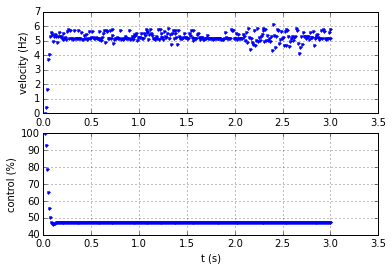

In [66]:
# SOLUTION 5
t = log[:,0]
position = log[:,1]
reference = log[:,2]
control = log[:,3]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

plt.subplot(2,1,1)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

In [67]:
# SOLUTION 6
ind, = np.where(t > 1)
vmean = np.mean(velocity[ind[0]:])
vstd = np.std(velocity[ind[0]:])
print('mean = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,vstd))

trcl = t[np.where(velocity >= 0.9*vmean)][1] - t[np.where(velocity >= 0.1*vmean)][0] 
taucl = trcl / 2.2
print('tr = {:5.3f}, tau = {:5.3f}'.format(trcl, taucl))

S = 1/(1 + Kp)
print('S = {:5.3f}'.format(S))
print('taucl/tauol = {:5.3f}'.format(taucl/tau))

mean = 5.284, standard deviation = 0.310
tr = 0.039, tau = 0.018
S = 0.500
taucl/tauol = 0.295


## Can you Beat the Motor Time-constant?

**TASKS:**
1. Write python code that sets the controller as open-loop, resets the controller logger and set the `reference_mode` to let the on-board potentiometer control the DC motor
2. Experiment with the potentiometer and *learn* where the potentiometer has to be
positioned for the motor to reach 8Hz
3. Move the potentiometer back to the up position (0% control voltage)
4. Move the potentiometer so as to make the motor reach and stay at 8Hz
5. Plot the time *vs* velocity and calculate your time-constant

**QUESTIONS:**
1. Did you make it faster than the open-loop time-constant?
2. What about the closed-loop time-constant?
3. What was your *secret*?

In [68]:
# YOUR SOLUTION HERE

## Integral Control

One problem when using a proportional controller to control the velocity of the DC motor is that the velocity does not actually **track** the reference: there is always a need for some error to exist so that the motor can continue to run. Integral control is one way to overcome this problem. In addition to a proportional control term we have an **integrator** that *accumulates* the error signal, as represented by the block-diagram:

<img src="figure6.png" width="650">

In the presence of a positive error signal the output of the integrator continues to grow. When the error is zeroed, the integrator stops acumulating but holds a constant control output that will offset the system in the desired way. The resulting controller is called a **proportional-integral-controller**, or simply **PI-controller**. 

With integral control it is possible to **track constant references** while keeping the gains small. Integral control is the most widely use form of control algorithm and can be found, for instance in your vehicle's cruise control.

**TASKS:**
1. Run the following code to implement a proportional-integral velocity controller
2. Import the data and plot time vs velocity and time vs reference and control
3. Discard the first second of data and use `np.mean` and `np.std` to calculate the average and standard deviation of the velocity
4. Calculate the ratio between the average velocity and the reference velocity
5. Have a group mate touch the top of the big pulley with his or her finger and apply a gentle force trying to stop the motor. Make sure the force does not completely stop the motor, as this may damage the motor
6. Repeat the above steps with a integral gain `Ki` equal to 0.1 then 10

**QUESTIONS:**
1. Did the closed-loop controller achieve the reference velocity?
2. What happened when your group mate disturbed the pulley?
3. What happened to the control as your group mate disturbed the pulley?
4. Can you name processes in your body that are regulated  like that?
5. What is the effect of a small integral gain?
6. What is the effect of a large integral gain?

In [69]:
Kp = 1
Ki = 1
K1 = Kp / a
K2 = Ki / a / tau
vmax = 12
controller.set_controller1(VelocityController(PID(K1, K2, 0, vmax)))
print('Kp = {:5.3f}, Ki = {:5.3f}, vmax = {:5.3f}'.format(Kp,Ki,vmax))

Kp = 1.000, Ki = 1.000, vmax = 12.000


In [70]:
vreference = 10
controller.reset_logger()
controller.set_encoder1(0)
with controller:
    controller.set_reference1(100*vreference/vmax)
    time.sleep(3)
log = controller.get_log()

In [71]:
# Solution 7

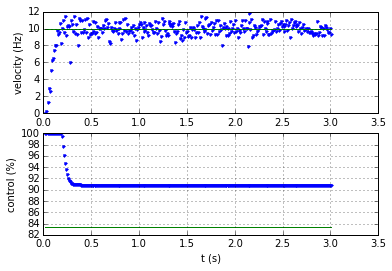

In [72]:
# SOLUTION 7
t = log[:,0]
position = log[:,1]
reference = log[:,2]
control = log[:,3]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

plt.subplot(2,1,1)
plt.plot(t, velocity, '.', t, reference * vmax/100, '-')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, control, '.', t, reference, '-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

## Revisiting Position Control

Because position is the integral of the velocity, proportional position control can in fact be seen as a form of pure integral control! As seen with velocity feedback, it is advantageous to combine and integral term with a proportional term. Since the integrator affects the output, that is our output already comes integrated, we can create the effect of a "proportional" term by adding a **derivative** term into the controller. This is represented in the block diagram:

<img src="figure7.png" width="650">

A controller that combines proportional and derivative actions is known as a **proportional-derivative-controller** or simply a **PD-controller**. Likewise, a controller that combines proportional, integral and derivative actions is known as a **proportional-integral-derivative-controller** or simply a **PID-controller**. Some people estimate that PID control accounts for more than 90% of all controllers deployed in the world.

**TASKS:**
1. Run the following code to implement a proportional-derivative position controller
2. Import the data and plot time *vs* position, time *vs* reference and control and time *vs* velocity
3. Repeat the above steps with a proportional gain `Kp` equal to 0.1 then 10

**QUESTIONS:**
1. Compare the responses with an without the derivative term
2. Contrast the control signal in both cases
3. Is position related to the control signal by a gain?
4. How could you calculate the closed-loop gain in the case of position control?

In [73]:
Kp = 1
K1 = Kp / a / tau
Kd = 1
K2 = Kd / a
pmax = 12
controller.set_controller1(PID(K1, 0, K2, pmax))
print('Kp = {:5.3f}, Kd = {:5.3f}, pmax = {:5.3f}'.format(Kp,Kd,pmax))

Kp = 1.000, Kd = 1.000, pmax = 12.000


In [74]:
preference = 10
controller.reset_logger()
controller.set_encoder1(0)
with controller:
    controller.set_reference1(100*preference/pmax)
    time.sleep(3)
log = controller.get_log()

In [75]:
# Solution 8

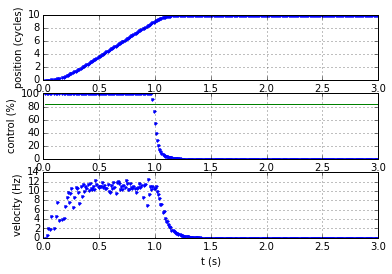

In [76]:
# SOLUTION 8
t = log[:,0]
position = log[:,1]
reference = log[:,2]
control = log[:,3]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

plt.subplot(3,1,1)
plt.plot(t, position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(3,1,2)
plt.plot(t, control, '.', t, reference, '-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(3,1,3)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

## Servo Control

A servo is a motor that is attached to a position feedback device. It is used by commanding the reference position rather than the motor voltage.

**TASKS:**
1. Write python code that sets the controller as closed-loop with proportional-integral-derivative position control, resets the controller logger and set the `reference_mode` to let the on-board potentiometer control the DC motor
2. Set all the gains to zero except proportional
3. Experiment with the potentiometer to see if the motor tracks your movements
4. Try to move the pulley after the servo has stoped
5. Plot time *vs* position and reference
6. Experiment with various proportional control gains
7. Add derivative gain as before

**QUESTIONS:**
1. How did the gain affect the response of the servo to changes in the potentiometer?
2. Which gains are the *slowest*? Which gains are the *fastest*?
3. How did the gain affect the response of the servo when you tried to move the pulley?
4. Can you think of other systems that operate in a similar way?

In [77]:
# YOUR SOLUTION HERE

## Marble Elevator

**WARNING:** Make sure this is the last experiment you do

**WARNING:** Make sure the hook is next to the pulley when you reset the encoder. Otherwise you may end up *wrapping* your elevator a couple of times around the pulley.

For this experiment you will need to release the fishing line and its hook from the large pulley.

**TASKS:**
1. Repeat the same setup as in the **Servo Control** but this time **do not** let the onboard potentiometer control the DC motor
2. Attach a bag of marbles with approximately 0.5 Kg (the load) to the string hook. Make sure the hook is positioned as close as possible to the pulley when your code resets the encoder. If needed, manually wind up the fishing line
3. Command the elevator go down and up by changing the position reference
4. Repeat the experiment but this time make sure that you put enough marbles in the bag so that the motor starts moving when the controller is off. Be careful before you turn off the controller as the bag of marbles will simply drop
5. Adjust the gains as needed

**QUESTIONS:**
1. How does the load affect the behavior of the system?
2. Did you have to modify the control gain for the system to perform as well as in the unloaded case?
3. What happened when the bag of marbles was too heavy? How could you fix this problem?

In [78]:
# YOUR SOLUTION HERE

#Solutions:

## Solutions 1, 2, 3, 4

## Solutions 5, 6

## Solution 7

## Solution 8